# Table Segmentation for Optical Character Recognition (OCR)

**Python** version: 3.7.7   
**OpenCV** version: 4.3.0.36   
**numpy** version: 1.19.2   
**matplotlib** version: 3.2.2   

This Python Jupyter notebook presents some basic image processing techniques useful for the segmentation of tables. 
It uses an example table from the [Bozner Zeitung]( https://digital.tessmann.it/tessmannDigital/Zeitungsarchiv/Monatsuebersicht/Zeitung/2/1842;jsessionid=6134EF3892401068CFB26FE42CBC1E64) and illustrates the steps required to segment the table in its data fields.  

The required libraries are imported:

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

The exemple table is loaded and plotted:

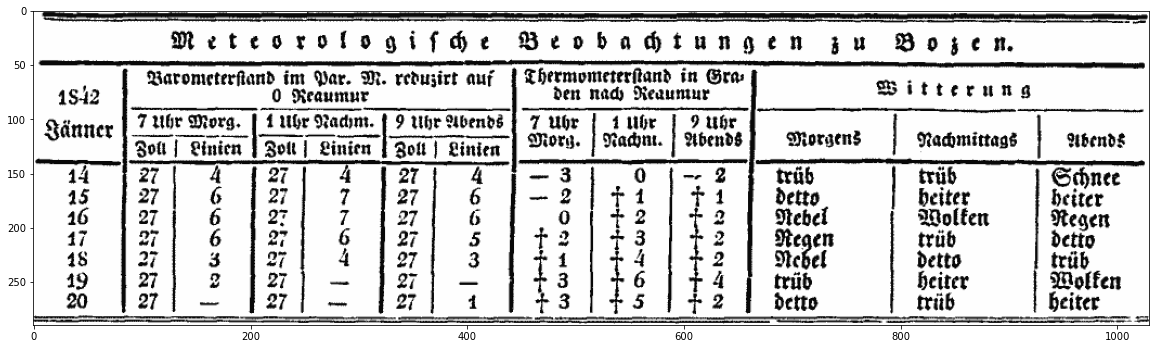

In [2]:
img_rgb = cv2.imread("01-21-1842.png")  

plt.figure(figsize=(20,15))             
plt.imshow(img_rgb, cmap="gray")
plt.show()

In [3]:
img_rgb.shape

(290, 1030, 3)

## Masking of the header and footer regions

The header and footer regions do not contain relevant data fields, thus they will be covered by a customized mask.  
In order to generate such a mask, the horizontal lines next to the data region have to be detected. This requires some image processing steps. 

The image is inverted.

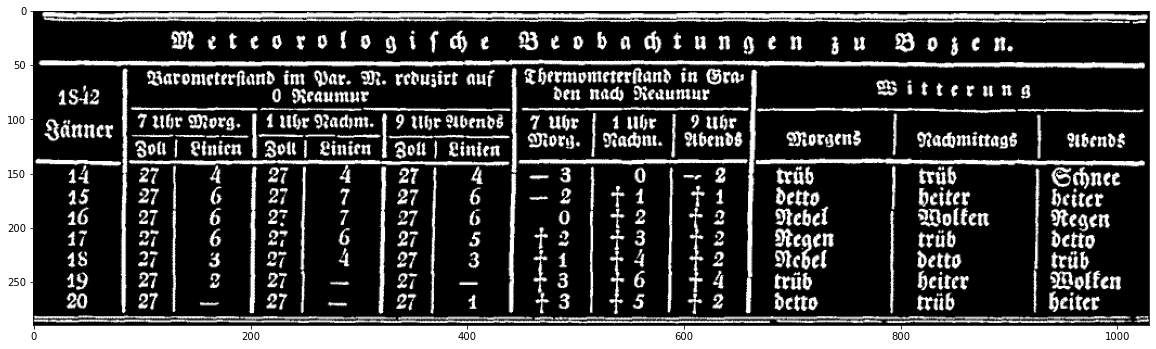

In [4]:
img_gr = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)  
inverted = cv2.bitwise_not(img_gr)                  

plt.figure(figsize=(20,15))
plt.imshow(inverted, cmap="gray")
plt.show()

Thresholding and binarisation are prerequisites for the extraction of contours, structuring elements, etc. from images.

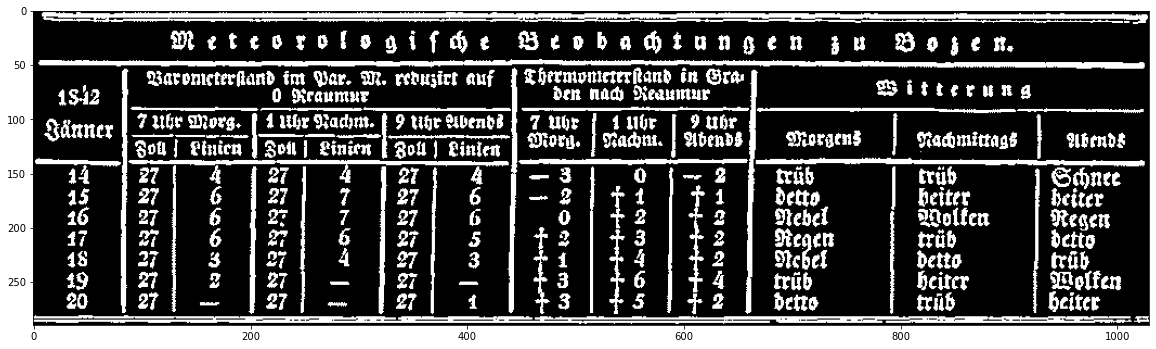

In [5]:
thresh_bin = cv2.adaptiveThreshold(inverted, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, -2)

plt.figure(figsize=(20,15))
plt.imshow(thresh_bin, cmap="gray")
plt.show()

The vertical structures of the image, that exceed a certain size (in this case 1/30 of the image width) are extracted.

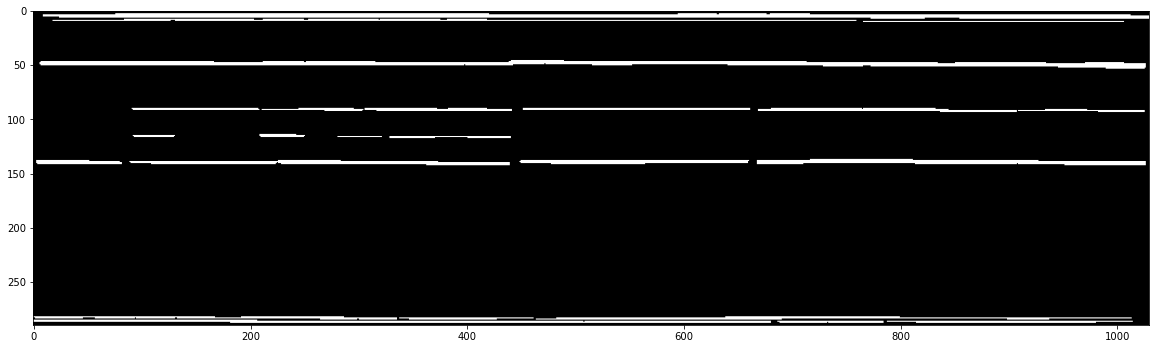

In [6]:
# size of the horizontal structures to be extracted 
hor_ax_size = thresh_bin.shape[1] // 30  # in this case 1/30 of the image width is a good value

horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (hor_ax_size, 1))

horizontal = cv2.erode(thresh_bin, horizontalStructure)
horizontal = cv2.dilate(horizontal, horizontalStructure)

plt.figure(figsize=(20,15))
plt.imshow(horizontal, cmap="gray")
plt.show()

This optional step leads to a fusion of the horizontal elements located at similar vertical positions.

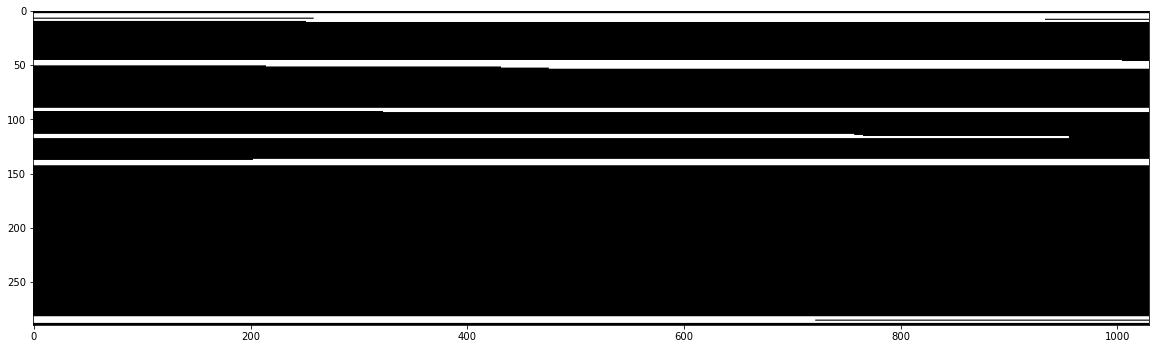

In [7]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(thresh_bin.shape[1], 1))
dilated_h = cv2.dilate(horizontal, kernel, iterations=1)

plt.figure(figsize=(20,20))
plt.imshow(dilated_h, cmap='gray')
plt.show()

The crucial horizontal structures of the table are extracted. In order to generate a customized mask, we need to know the exact vertical positions (which means: the y-coordinates) of the lowest two horizontal structures.  

Therefore, we extract the x- and y-coordinates of the points that constitute the contours of each structure.

In [8]:
contours, hierarchy = cv2.findContours(dilated_h, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

The variable **contours** contains a list of the coordinates of all horizontal structures. We filter this list and obtain the for us relevant y-coordinates for each horizontal structure. 

In [9]:
list_y_all_cont = []
for cont in contours: 
    list_y_cont = []
    for n in range(0, len(cont)):
        a = 2*n + 1
        y = np.take(cont, a)
        list_y_cont.append(y)
    list_y_all_cont.append(list_y_cont)

The new list contains the important y-coordinates of each horizontal structure.

In [10]:
list_y_all_cont

[[282, 287, 287, 286, 286, 285, 284, 284, 282],
 [137, 138, 138, 142, 142, 137],
 [114, 117, 117, 116, 116, 115, 115, 114],
 [90, 92, 92, 93, 93, 90],
 [46, 50, 50, 51, 51, 52, 52, 53, 53, 47, 47, 46],
 [3, 6, 6, 7, 8, 8, 9, 9, 10, 10, 9, 9, 8, 7, 7, 3]]

For each structure we extract the highest and the lowest y-coordinate value.

In [11]:
cont_max_y_all =[]
cont_min_y_all =[]

for item in list_y_all_cont:
    item_cont = np.asarray(item)
    cont_max_y = item_cont.max()
    cont_max_y_all.append(cont_max_y)
    
    cont_min_y = item_cont.min()
    cont_min_y_all.append(cont_min_y)

In [12]:
cont_max_y_all

[287, 142, 117, 93, 53, 10]

In [13]:
cont_min_y_all

[282, 137, 114, 90, 46, 3]

From the list of maximal values (cont_max_y_all) we are interested in the value closest to the horizontal image axis.

In [14]:
param_m_u = min(cont_max_y_all, key=lambda x:abs(x-img_rgb.shape[0]/2))
param_m_u

142

From the list of minimal values (cont_min_y_all) we are interested in the value closest to the lower image border.

In [15]:
param_m_d = min(cont_min_y_all, key=lambda x:abs(x-img_rgb.shape[0]*0.9))
param_m_d

282

The 2 parameters **param_m_u** and **param_m_d** allow us to set the upper and lower margins of the customized mask.

After these preprocessing steps we can assemble the customized mask required for removing the header and footer regions.

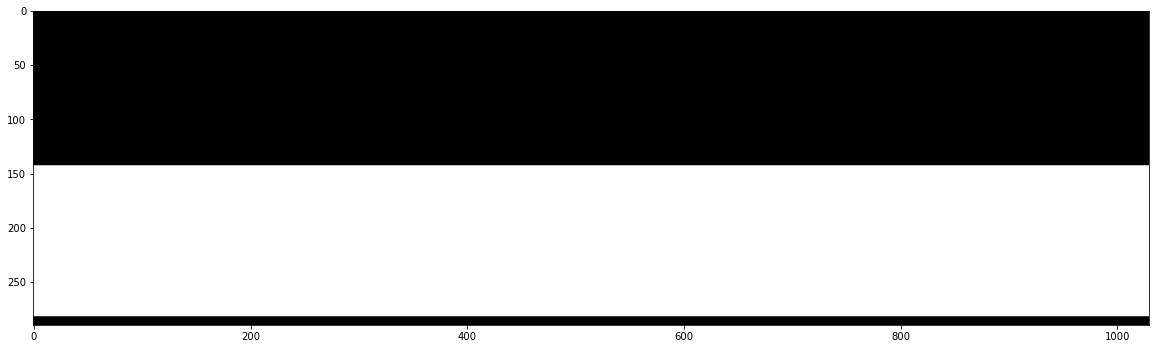

In [16]:
frame = np.full((img_rgb.shape[0], img_rgb.shape[1]), fill_value=255, dtype=np.uint8)
mask_color = (0, 0, 0)

m_u = cv2.rectangle(frame, (0, 0), (img_rgb.shape[1], param_m_u), mask_color, -1) 
m_d = cv2.rectangle(frame, (0, param_m_d), (img_rgb.shape[1], img_rgb.shape[0]), mask_color, -1) 

customized_mask = m_u + m_d

plt.figure(figsize=(20,15))
plt.imshow(customized_mask, cmap="gray")
plt.show()

We now can apply this customized mask to the initial image. Header and footer regions are removed.

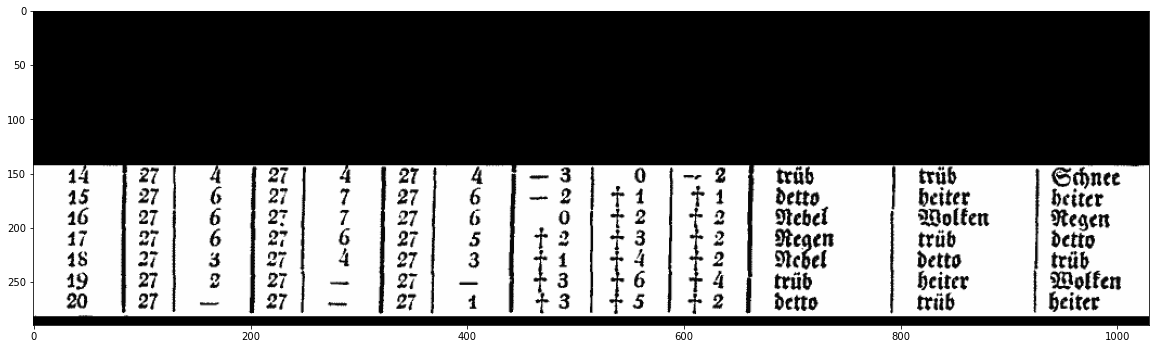

In [17]:
masked_img = cv2.bitwise_and(img_rgb, img_rgb, mask=customized_mask)
plt.figure(figsize=(20,20))
plt.imshow(masked_img, cmap='gray')
plt.show()

## Vertical segmentation of the table

The next step towards the segementation of the table in data fields is the masking of the vertical bars that separate the table columns. We do this by extending the customized mask we just created with additional masks that cover the bars.

In order to do so, we need to generate an inverted version of the masked image above. 

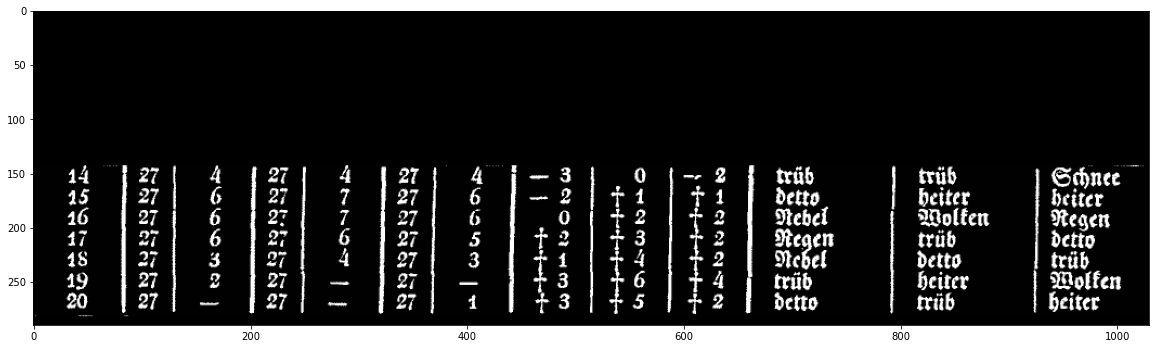

In [18]:
helper_array = np.full((img_rgb.shape[0], img_rgb.shape[1]), fill_value=0, dtype=np.uint8)
masked_img_inverted = cv2.bitwise_not(img_gr, helper_array, mask=customized_mask) 

plt.figure(figsize=(20,20))
plt.imshow(masked_img_inverted, cmap='gray')
plt.show()

Spots of ink or dirt can heavily disturb the detection of the relevant vertical structures. Therefore, a cleaning procedure (which means cycles of erosion and dilation) is relevant at this point. It can be done before the thresholding and binarization.

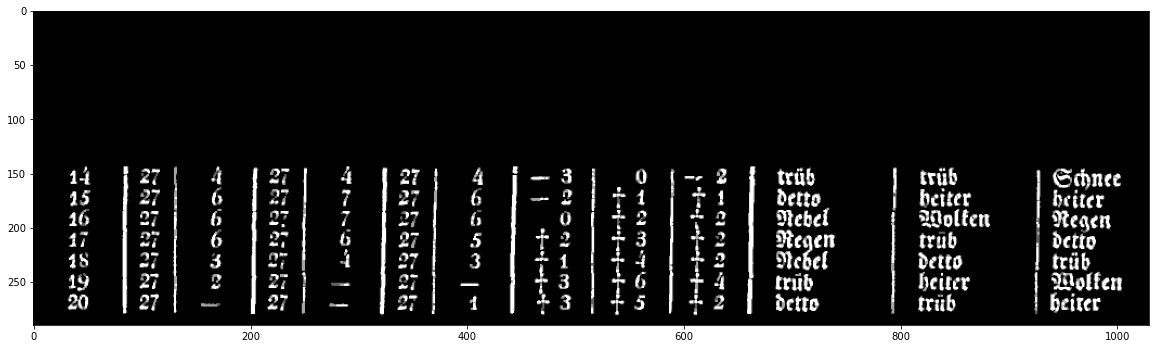

In [19]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(2,2))
erode = cv2.erode(masked_img_inverted, kernel, iterations=1)
dilate = cv2.dilate(erode, kernel, iterations=1)

thresh_bin_m = cv2.adaptiveThreshold(dilate, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, -2)

plt.figure(figsize=(20,20))
plt.imshow(dilate, cmap='gray')
plt.show()

Extracting the vertical structures of the table in a similar way as done for the horizontal structures does not work properly, due to the vertically arranged **+** characters in some columns. These characters mimic a separating bar. Therefore, we follow an alternative approach here.

We dilate all contours in vertical direction and extract the countours for the vertical bars.

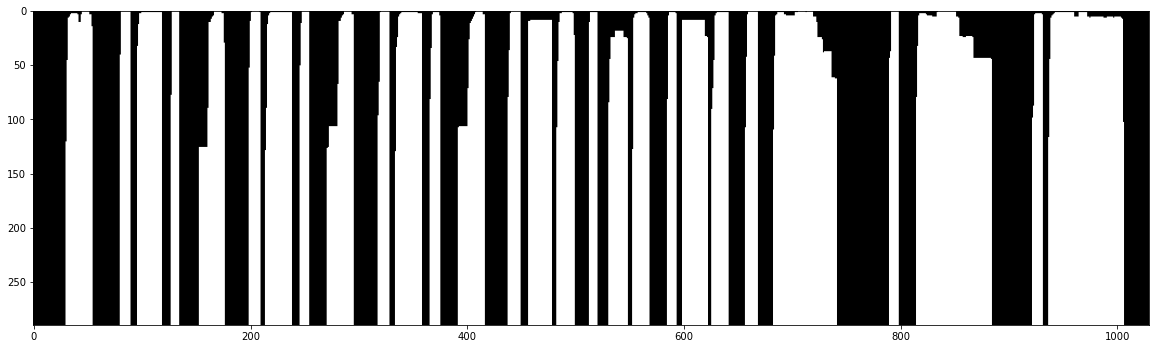

In [20]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(5, img_rgb.shape[0]))
dil_col = cv2.dilate(thresh_bin_m, kernel, iterations=1)

plt.figure(figsize=(20,20))
plt.imshow(dil_col, cmap='gray')
plt.show()

We extract the x- and y-coordinates of the points that constitute the contours of each structure.

In [21]:
contours, hierarchy = cv2.findContours(dil_col, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [22]:
len(contours)

28

As we can see, we get 28 vertical structures. Now we need to extract the x-coordinates of these structures and store them in a sorted list (list_x_all_cont).

In [23]:
list_x_all_cont = []
for cont in contours: 
    list_x_cont = []
    for n in range(0, len(cont)):
        a = 2*n
        x = np.take(cont, a)
        list_x_cont.append(x)
    list_x_all_cont.append(list_x_cont)
list_x_all_cont.sort()

The bar structures have specific positions in that list, e.g. the first bar appears at position 2 (regarded from left), which means its index is 1. We filter the bar structures out of the contour list and extract the highest and lowest x-coordinate for each bar. These coordinates constitute the masking parameters for our extended customized mask.  
In case that something goes wrong and we are faced with something else than 28 vertical structures, we use some default masking parameters.

In [24]:
if len(list_x_all_cont) == 28:
    bar_1 = list_x_all_cont[1]
    bar_2 = list_x_all_cont[3]
    bar_3 = list_x_all_cont[5]
    bar_4 = list_x_all_cont[7]
    bar_5 = list_x_all_cont[9]
    bar_6 = list_x_all_cont[11]
    bar_7 = list_x_all_cont[13]
    bar_8 = list_x_all_cont[16] 
    bar_9 = list_x_all_cont[19] 
    bar_10 = list_x_all_cont[22]
    bar_11 = list_x_all_cont[24] 
    bar_12 = list_x_all_cont[26]

    bar_list = [bar_1, bar_2, bar_3, bar_4, bar_5, bar_6, bar_7, bar_8, bar_9, bar_10, bar_11, bar_12]

    masking_params_x = [] 
    for item in bar_list:
        item_cont = np.asarray(item)
        cont_min_x = item_cont.min()
        cont_max_x = item_cont.max()
        masking_params_x.append((cont_min_x, cont_max_x))
else: 
    masking_params_x = [(88,97), (135,141), (207,215), (255,262), (326,335), (376,382), (447,455), 
                        (521,527), (597,605), (672,681), (795,805), (925,935)]

In [25]:
masking_params_x

[(80, 89),
 (127, 134),
 (199, 209),
 (246, 254),
 (318, 328),
 (366, 375),
 (438, 449),
 (513, 520),
 (585, 593),
 (657, 668),
 (790, 798),
 (922, 931)]

We use these masking parameters in order to extend our customized mask in a way that we also cover the vertical bars.

In [26]:
frame = np.zeros((img_rgb.shape[0], img_rgb.shape[1]), dtype=np.uint8)
frame.fill(255)
mask_color = (0, 0, 0)

m_u = cv2.rectangle(frame, (0, 0), (img_rgb.shape[1], param_m_u), mask_color, -1)
m_d = cv2.rectangle(frame, (0, param_m_d), (img_rgb.shape[1], img_rgb.shape[0]), mask_color, -1) 

m_v1 = cv2.rectangle(frame, ((masking_params_x[0][0] - 6), 0), ((masking_params_x[0][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v2 = cv2.rectangle(frame, ((masking_params_x[1][0] - 6), 0), ((masking_params_x[1][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v3 = cv2.rectangle(frame, ((masking_params_x[2][0] - 6), 0), ((masking_params_x[2][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v4 = cv2.rectangle(frame, ((masking_params_x[3][0] - 6), 0), ((masking_params_x[3][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v5 = cv2.rectangle(frame, ((masking_params_x[4][0] - 6), 0), ((masking_params_x[4][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v6 = cv2.rectangle(frame, ((masking_params_x[5][0] - 6), 0), ((masking_params_x[5][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v7 = cv2.rectangle(frame, ((masking_params_x[6][0] - 6), 0), ((masking_params_x[6][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v8 = cv2.rectangle(frame, ((masking_params_x[7][0] - 6), 0), ((masking_params_x[7][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v9 = cv2.rectangle(frame, ((masking_params_x[8][0] - 6), 0), ((masking_params_x[8][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v10 = cv2.rectangle(frame, ((masking_params_x[9][0] - 6), 0), ((masking_params_x[9][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v11 = cv2.rectangle(frame, ((masking_params_x[10][0] - 6), 0), ((masking_params_x[10][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v12 = cv2.rectangle(frame, ((masking_params_x[11][0] - 6), 0), ((masking_params_x[11][1] + 6), img_rgb.shape[0]), mask_color, -1)

mask_v = m_u + m_d + m_v1 + m_v2 + m_v3 + m_v4 + m_v5 + m_v6 + m_v7 + m_v8 + m_v9 + m_v10 + m_v11 + m_v12

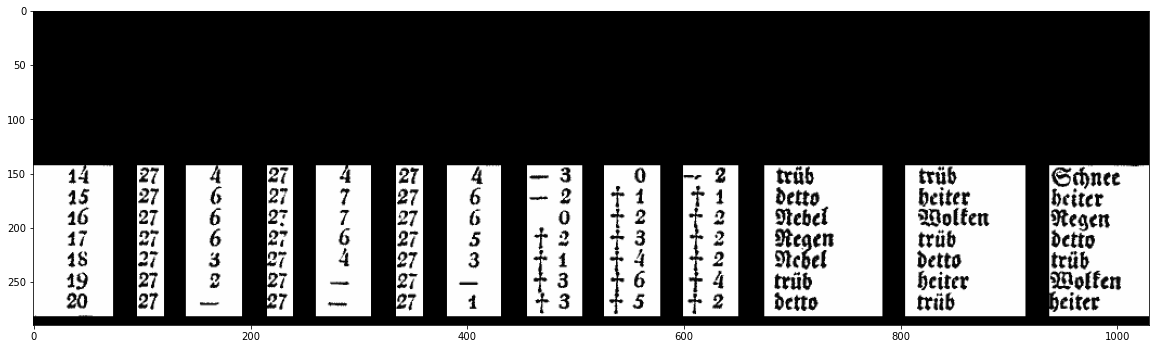

In [27]:
masked_vert = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_v)
plt.figure(figsize=(20,20))
plt.imshow(masked_vert, cmap='gray')
plt.show()

## Horizontal segmentation of the table

We can follow a very similar procedure in order to segment the table horizontally and to obtain the rows of the table. However, we have to deal with the fact that the data rows are much closer to each other than the data columns. This makes the horizontal segmentation a bit more tricky.

We have to avoid that the vertically arranged **+** characters, that overlap partially, interfere with our segmentation procedure. We can do that by temporarily excluding the numeric data columns from the table. 

In order to do so, we adapt our mask to a helper mask that only lets the categorical fields uncovered.

In [28]:
frame = np.zeros((img_rgb.shape[0], img_rgb.shape[1]), dtype=np.uint8)
frame.fill(255)
mask_color = (0, 0, 0)

m_u = cv2.rectangle(frame, (0, 0), (img_rgb.shape[1], param_m_u), mask_color, -1)
m_d = cv2.rectangle(frame, (0, param_m_d), (img_rgb.shape[1], img_rgb.shape[0]), mask_color, -1) 

m_help = cv2.rectangle(frame, (0, 0), ((masking_params_x[9][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v11 = cv2.rectangle(frame, ((masking_params_x[10][0] - 6), 0), ((masking_params_x[10][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v12 = cv2.rectangle(frame, ((masking_params_x[11][0] - 6), 0), ((masking_params_x[11][1] + 6), img_rgb.shape[0]), mask_color, -1)

helpermask = m_u + m_d + m_help + m_v11 + m_v12

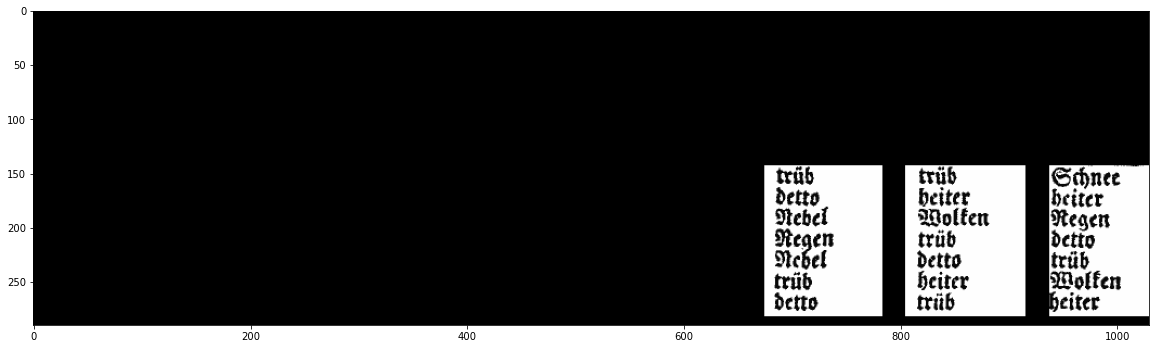

In [29]:
masked_helper = cv2.bitwise_and(img_rgb, img_rgb, mask=helpermask)
plt.figure(figsize=(20,20))
plt.imshow(masked_helper, cmap='gray')
plt.show()

Again we have to perform the image inversion and cleaning steps introduced above.

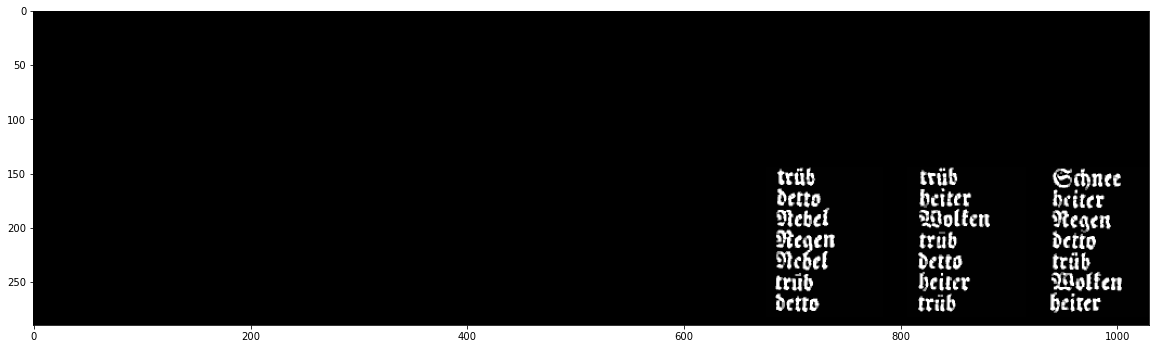

In [30]:
helper_array = np.full((img_rgb.shape[0], img_rgb.shape[1]), fill_value=0, dtype=np.uint8)
helpermasked_img_inverted = cv2.bitwise_not(img_gr, helper_array, mask=helpermask) 

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(2,2))
erode = cv2.erode(helpermasked_img_inverted, kernel, iterations=1)
dilate = cv2.dilate(erode, kernel, iterations=1)

plt.figure(figsize=(20,20))
plt.imshow(dilate, cmap='gray')
plt.show()

As we can see, the words **Regen** and **Nebel** in the left column are connected. We need to break this connection in order to be able to properly separate the corresponding rows.  

Therefore, we apply additional image processing steps such as Gaussian blurring and customized thresholding.

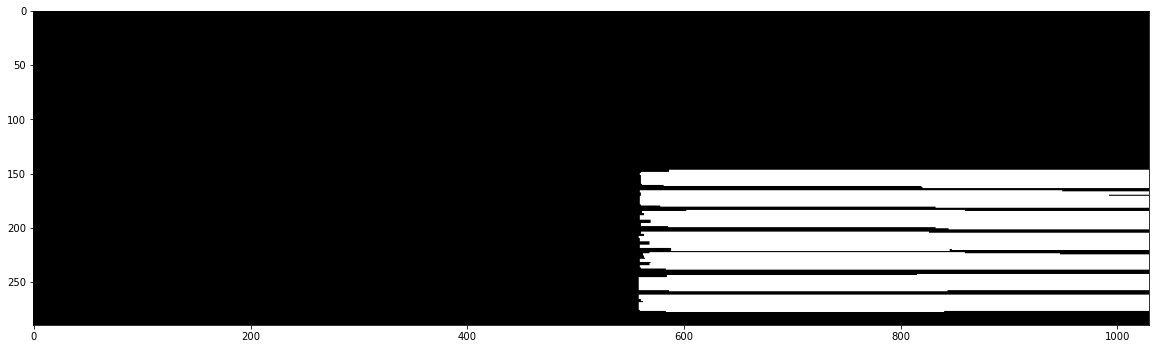

In [31]:
blur = cv2.GaussianBlur(dilate,(3,3), 0, 0)
ret, thr_bin_wit = cv2.threshold(blur, 210, 255, cv2.THRESH_BINARY)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(int(img_rgb.shape[1]/4), 2))
dil_row = cv2.dilate(thr_bin_wit, kernel, iterations=1)

plt.figure(figsize=(20,20))
plt.imshow(dil_row, cmap='gray')
plt.show()

The now following steps resemble the procedure performed above for the extraction of the vertical structures. We apply it here for the 7 horizontal structures that we have. 

In [32]:
contours, hierarchy = cv2.findContours(dil_row, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
len(contours)

7

In [33]:
if len(contours) == 7:
    cont_max_y_all = []
    cont_min_y_all = []
    list_y_all_cont = []
    
    for cont in contours: 
        list_y_cont = []
        for n in range(0, len(cont)):
            a = 2*n + 1
            y = np.take(cont, a)
            list_y_cont.append(y)
        list_y_all_cont.append(list_y_cont)

    for item in list_y_all_cont:
        item_cont = np.asarray(item)
        cont_max_y = item_cont.max()
        cont_min_y = item_cont.min()
        cont_max_y_all.append(cont_max_y)
        cont_min_y_all.append(cont_min_y)
        
    cutting_list = [cont_max_y_all[0]]
    
    for i in range (0,6):
        first = int(cont_min_y_all[i])
        second = int(cont_max_y_all[i+1])
        cutting = int((first + second)/2)
        cutting_list.append(cutting)
    cutting_list.append(cont_min_y_all[6])
else:
    cutting_list = [277, 259, 239, 220, 200, 180, 161, 144]

In [34]:
cutting_list

[277, 260, 240, 222, 202, 182, 164, 147]

The **cutting_list** contains the y-coordinates of the separation lines for the data rows. In case that something goes wrong and we are faced with something else than 7 horizontal structures, we use some default parameters for the separation lines.

## Full segmentation of the table in data fields

After extracting all relevant horizontal and vertical parameters, we can now assemble the final mask that fully segments the table in data fields.

In [35]:
boxlines_v = masking_params_x
boxlines_h = cutting_list

frame = np.zeros((img_rgb.shape[0], img_rgb.shape[1]), dtype=np.uint8)
frame.fill(255)
mask_color = (0, 0, 0)

m_u = cv2.rectangle(frame, (0, 0), (img_rgb.shape[1], param_m_u), mask_color, -1)
m_d = cv2.rectangle(frame, (0, param_m_d), (img_rgb.shape[1], img_rgb.shape[0]), mask_color, -1) 
m_l = cv2.rectangle(frame, (0, 0), (10, img_rgb.shape[0]), mask_color, -1) 
m_r = cv2.rectangle(frame, (img_rgb.shape[1] - 10, 0), (img_rgb.shape[1], img_rgb.shape[0]), mask_color, -1)

m_v1 = cv2.rectangle(frame, ((boxlines_v[0][0] - 6), 0), ((boxlines_v[0][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v2 = cv2.rectangle(frame, ((boxlines_v[1][0] - 6), 0), ((boxlines_v[1][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v3 = cv2.rectangle(frame, ((boxlines_v[2][0] - 6), 0), ((boxlines_v[2][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v4 = cv2.rectangle(frame, ((boxlines_v[3][0] - 6), 0), ((boxlines_v[3][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v5 = cv2.rectangle(frame, ((boxlines_v[4][0] - 6), 0), ((boxlines_v[4][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v6 = cv2.rectangle(frame, ((boxlines_v[5][0] - 6), 0), ((boxlines_v[5][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v7 = cv2.rectangle(frame, ((boxlines_v[6][0] - 6), 0), ((boxlines_v[6][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v8 = cv2.rectangle(frame, ((boxlines_v[7][0] - 6), 0), ((boxlines_v[7][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v9 = cv2.rectangle(frame, ((boxlines_v[8][0] - 6), 0), ((boxlines_v[8][1] + 6), img_rgb.shape[0]), mask_color, -1)

m_v10 = cv2.rectangle(frame, ((boxlines_v[9][0] - 6), 0), ((boxlines_v[9][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v11 = cv2.rectangle(frame, ((boxlines_v[10][0] - 6), 0), ((boxlines_v[10][1] + 6), img_rgb.shape[0]), mask_color, -1)
m_v12 = cv2.rectangle(frame, ((boxlines_v[11][0] - 6), 0), ((boxlines_v[11][1] + 6), img_rgb.shape[0]), mask_color, -1)

m_h1 = cv2.rectangle(frame, (0, boxlines_h[1]), (img_rgb.shape[1], boxlines_h[1]), mask_color, -1)
m_h2 = cv2.rectangle(frame, (0, boxlines_h[2]), (img_rgb.shape[1], boxlines_h[2]), mask_color, -1)
m_h3 = cv2.rectangle(frame, (0, boxlines_h[3]), (img_rgb.shape[1], boxlines_h[3]), mask_color, -1)
m_h4 = cv2.rectangle(frame, (0, boxlines_h[4]), (img_rgb.shape[1], boxlines_h[4]), mask_color, -1)
m_h5 = cv2.rectangle(frame, (0, boxlines_h[5]), (img_rgb.shape[1], boxlines_h[5]), mask_color, -1)
m_h6 = cv2.rectangle(frame, (0, boxlines_h[6]), (img_rgb.shape[1], boxlines_h[6]), mask_color, -1)


fullmask = m_u + m_d + m_l + m_r + m_v1 + m_v2 + m_v3 + m_v4 + m_v5 + m_v6 + m_v7 + m_v8 + m_v9 + m_v10 + m_v11 + m_v12 + m_h1 + m_h2 + m_h3 + m_h4 + m_h5 + m_h6

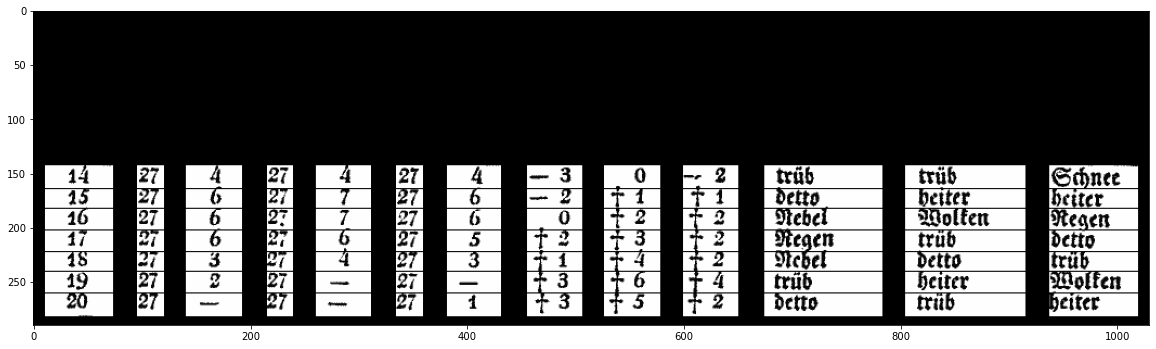

In [36]:
masked_final = cv2.bitwise_and(img_rgb, img_rgb, mask=fullmask)
plt.figure(figsize=(20,20))
plt.imshow(masked_final, cmap='gray')
plt.show()

The final mask (**fullmask**) generated here can be used to define the coordinates of each data field based on the data position. This is a prerequisite for further data extraction procedures by means of OCR.

---